In [1]:
import os.path
import warnings

from Model.radiation.real_gas_data.hitran import LookupTableFolder
from Model.radiation.real_gas_data.specific_humidity import p_altitude_convert, molecules
from centa_presentation.base import get_olr_area, eqv_ppmv

warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt
from Model.radiation.base import round_any
import Model.radiation.real_gas_data.hitran as hitran
import Model.radiation.real_gas_data.specific_humidity as humidity
from Model.radiation.real_gas_data.temperature_profiles import earth_temp, fixed_tropopause_temp, two_lapse_temp
from Model.radiation.real_gas import RealGas, transmission, B_wavenumber, optical_depth, sigma
from IPython.display import HTML
import numpy as np
import os
from tqdm.notebook import tqdm
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import sys
sys.path.append('/Users/joshduffield/Documents/StAndrews/Isca/')
from isca_tools.plot import label_subplots, fig_resize, update_linewidth, update_fontsize, savefig
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib

/Users/joshduffield/miniforge3/envs/ClimateModel/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


In [2]:
p_toa = 10  # Top of atmosphere pressure for this notebook (Pa)
n_bands = 200 # number of wavenumber bands in this notebook

In [3]:
# plotting info
lw_large = 1.8
im_width = 6.4

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']
colors_molecule = {'h2o': default_colors[0], 'co2': default_colors[1], 'ch4': default_colors[2], 'o3': default_colors[3], 'gray': 'gray',
                   'cfc12': default_colors[4]}
label_molecule = {'h2o': '$H_2O$', 'co2': '$CO_2$', 'ch4': '$CH_4$', 'o3': '$O_3$', 'gray': None, 'cfc12': 'CFC-12'}

leg_info = {'handlelength': 2, 'labelspacing': 1, 'columnspacing': 0.9, 'handletextpad': 1}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

# adjust update stuff for presentation
fig_resize_use = lambda x: fig_resize(x, im_width, ar=1.9)
update_linewidth_use = lambda x: update_linewidth(x, base_linewidth=0.5)
update_fontsize_use = lambda x: update_fontsize(x, base_fontsize=5.5)

## Set base temperature profile
This stays the same throughout notebook, same as gray case. Isothermal stratosphere and constant lapse rate of 6K/km in troposphere.

In [4]:
lapse_rate = 6 # lapse rate in kelvin per km (dry is 9.8)
lapse_strat = 0
h_tropopause = 12 # height of tropopause in km
h_top = 20
temp_surf = 290 # temperature of surface in K
temp_tropopause = temp_surf - lapse_rate * h_tropopause
# temp_profile_use = lambda x: fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
def temp_profile_use(x, y=lapse_strat):
    return two_lapse_temp(x, h_tropopause, h_top, temp_surf, lapse_rate, y)
# def temp_profile_use(x):
#     var = fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
#     var[var<= temp_tropopause] = temp_surf
#     return var

In [5]:
atmos_base = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                     q_funcs={'gray': humidity.constant_q}, q_funcs_args={'gray': (300,'co2')},
                     T_func=temp_profile_use, n_nu_bands=n_bands)
spectrum_tropopause = B_wavenumber(atmos_base.nu_bands['centre'], temp_tropopause) * np.pi
spectrum_surface = B_wavenumber(atmos_base.nu_bands['centre'], temp_surf) * np.pi

ax_lim_spectrum = [200, 1800]
ax_lim_flux = [0, 0.46]

In [6]:
# Modified function to preserve continuity
# chatgpt function to plot line only where mask satisfied
def get_continuous_segments(x, y, mask):
    segments = []
    current_x = [x[0]]
    current_y = [y[0]]
    current_state = mask[0]

    for i in range(1, len(x)):
        this_state = mask[i]
        if this_state != current_state:
            # Include boundary point to both segments
            current_x.append(x[i])
            current_y.append(y[i])
            segments.append((np.array(current_x), np.array(current_y), current_state))
            current_x = [x[i - 1], x[i]]
            current_y = [y[i - 1], y[i]]
            current_state = this_state
        else:
            current_x.append(x[i])
            current_y.append(y[i])
    segments.append((np.array(current_x), np.array(current_y), current_state))
    return segments

## Plot Spectrum and Absorption coefficient
Here we see the overlap between the absorption coefficient of each GHG under consideration with the radiation emitted from the surface.

Also give option if `show_earth_transmission=True`, to consider overlap between radiation that escapes from surface to space, with absorption coefficients. In this case, we highlight spectral regions where at least one GHG has absorption coefficient greater than 1.

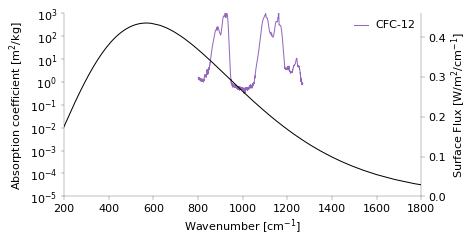

In [8]:
molecules_plot = ['co2', 'ch4', 'h2o']
molecules_plot = ['cfc12']
alpha_faint = 1
# alpha_faint = 1
show_earth_transmission = False    # show radiation from surface that reaches space in earth like climate
absorb_coef_nu_centre = {key: np.zeros(n_bands) for key in ['co2', 'ch4']}
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in molecules_plot:
    if key == 'cfc12':
        continue
    j = 0
    nu_use, absorb_coef_use = hitran.plot_absorption_coefficient(key, hitran.p_reference, temp_surf, do_plot=False)
    if show_earth_transmission:
        if key == 'h2o':
            continue
        absorb_coef_nu_centre[key] = np.interp(atmos_base.nu_bands['centre'], nu_use, absorb_coef_use)
        segments = get_continuous_segments(nu_use, absorb_coef_use, absorb_coef_use<1)
        # Plot
        for seg_x, seg_y, is_low in segments:
            alpha = alpha_faint if is_low else 1.0
            if not is_low and j==0:
                label_use = label_molecule[key]
                j+= 1
            else:
                label_use = None
            ax.plot(seg_x, seg_y, color=colors_molecule[key], alpha=alpha, label=label_use)
    else:
        ax.plot(nu_use, absorb_coef_use, color=colors_molecule[key], label=label_molecule[key])
    if key == 'h2o' and show_earth_transmission:
        continue
ax.set_xlim(ax_lim_spectrum)
ax.set_yscale('log')
ax.yaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_locator(plt.NullLocator())
# ax.set_yticks(None)
ax.set_ylim(10**-5, 10**3)
ax.set_xlabel('Wavenumber [cm$^{-1}$]')
ax.set_ylabel('Absorption coefficient [m$^2$/kg]')

ax2 = ax.twinx()
# ax2.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='k')
if show_earth_transmission:
    absorb_coef_nu_centre['max'] = np.max(np.stack(list(absorb_coef_nu_centre.values())), axis=0)       # get max across all molecules

    # Get segments with shared points
    segments = get_continuous_segments(atmos_base.nu_bands['centre'], olr_breakdown_earth[3]['surface'], absorb_coef_nu_centre['max']<1)
    # Plot
    for seg_x, seg_y, is_low in segments:
        alpha = alpha_faint if is_low else 1.0
        ax2.plot(seg_x, seg_y, color='k', alpha=alpha)
else:
    ax2.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='k')

ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylabel('Surface Flux [W/m$^2$/cm$^{-1}$]')
ax2.set_ylim(ax_lim_flux)

if 'cfc12' in molecules_plot:
    nu_cfc, abs_cfc = hitran.load_from_cross_section_xsc(None, None, None, 'CFC12', True)
    n_convolve = 1000       # smooth out absorption peaks
    ax.plot(np.convolve(nu_cfc[:-1], np.ones(n_convolve)/n_convolve, 'valid'), np.convolve(abs_cfc, np.ones(n_convolve)/n_convolve, 'valid'),
            color=colors_molecule['cfc12'], label=label_molecule['cfc12'])

update_linewidth_use(fig)
if 'ch4' in molecules_plot or 'cfc12' in molecules_plot:
    add_legend(ax, loc='upper right')
if show_earth_transmission and alpha_faint != 1:
    ax.axhline(1, color='k', lw=ax_linewidth)
update_fontsize_use(fig)
plt.show()
# savefig(fig)

## Effect of adding GHG to the OLR
Here, we see the effect of adding a given mass of GHG on the OLR, starting from an empty atmosphere. CO2 and methane are well mixed, so mass added throughout the atmosphere. For H2O, we set a constant gradient to 0 at tropopause, so x-axis value indicates surface mass.

In [9]:
co2_conc = np.arange(0, 1000+50, 50)
co2_conc[0] = 1   # otherwise get 0 error
n_conc = co2_conc.size
olr_breakdown = {key2: {key: np.zeros((n_conc, n_bands)) for key in ['all', 'surface', 'atmos']} for key2 in ['co2', 'ch4', 'gray', 'h2o']}
pbar = tqdm(total=n_conc*3)
for key in ['co2', 'ch4', 'gray']:
    for i in range(n_conc):
        key_mass = 'co2' if key=='gray' else key
        atmos_use = RealGas(nz='auto', ny=1, molecule_names=[key], p_toa=p_toa,
                             q_funcs={key: humidity.constant_q}, q_funcs_args={key: (eqv_ppmv(key_mass, co2_conc[i]), key_mass)},
                             T_func=temp_profile_use, n_nu_bands=n_bands)
        olr_breakdown[key]['all'][i] = atmos_use.up_flux[0]
        var = atmos_use.get_flux(include_olr_breakdown=True)[2]
        olr_breakdown[key]['surface'][i] = var['surface']
        pbar.update(1)
    olr_breakdown[key]['atmos'] = olr_breakdown[key]['all'] - olr_breakdown[key]['surface']

  0%|          | 0/63 [00:00<?, ?it/s]

In [10]:
key = 'h2o'
for i in tqdm(range(n_conc)):
    key_mass = 'co2' if key=='gray' else key
    atmos_use = RealGas(nz='auto', ny=1, molecule_names=[key], p_toa=p_toa,
                         q_funcs={key: humidity.gradient_q}, q_funcs_args={key: (eqv_ppmv(key, co2_conc[i]), 0, h_tropopause*1000, key)},
                         T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown[key]['all'][i] = atmos_use.up_flux[0]
    var = atmos_use.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown[key]['surface'][i] = var['surface']
    pbar.update(1)
olr_breakdown[key]['atmos'] = olr_breakdown[key]['all'] - olr_breakdown[key]['surface']

  0%|          | 0/21 [00:00<?, ?it/s]

In [11]:
linestyle_olr = {'all': '-', 'surface': '--', 'atmos': ':'}
label_olr = {'all': 'Total', 'surface': 'Surface', 'atmos': 'Atmosphere'}
olr_area_tropopause = get_olr_area(atmos_base, flux=B_wavenumber(atmos_base.nu_bands['centre'], temp_tropopause) * np.pi)
olr_area_surface = get_olr_area(atmos_base, flux=B_wavenumber(atmos_base.nu_bands['centre'], temp_surf) * np.pi)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


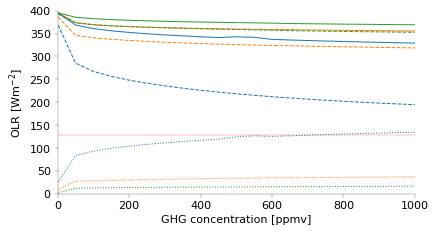

In [12]:
plot_diff = False
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key2 in ['co2', 'ch4', 'h2o']:
    # if not plot_diff and key2 == 'ch4':
    #     continue
    for key in olr_breakdown[key2]:
        var = [get_olr_area(atmos_base, flux=olr_breakdown[key2][key][i]) for i in range(n_conc)]
        if plot_diff and key != 'atmos':
            var -= olr_area_surface
        ax.plot(co2_conc, var, color=colors_molecule[key2], linestyle=linestyle_olr[key], label=label_olr[key] if key2 == 'gray' else None)
# ax.plot(co2_conc, olr_breakdown['atmos'])

update_linewidth_use(fig)
add_legend(ax, loc='center right')
update_fontsize_use(fig)
ax.set_xlabel('GHG concentration [ppmv]')
ax.set_xlim(0, co2_conc[-1])
if not plot_diff:
    ax.axhline(olr_area_tropopause, color='r', lw=ax_linewidth)
    ax.set_ylim(0, 400)
    ax.set_ylabel('OLR [Wm$^{-2}$]')
else:
    ax.set_ylabel('OLR change [Wm$^{-2}$]')
    ax.axhline(0, color='k', lw=ax_linewidth)
    ax.set_ylim(-100, 100)
plt.show()
# savefig(fig)

### GIF showing spectra change
The above shows the integrated OLR across all wavenumbers. Below, we show how the entire OLR spectra evolves as more GHG is added.

In [13]:
dpi_gif = 800
fig, ax = plt.subplots(1, 1, dpi=dpi_gif)
fig_resize_use(fig)
fig.subplots_adjust(bottom=0.17)  # or top/left/right

def animate(n, fig, key2):
    ax = fig.axes[0]
    ax.clear()
    for key in olr_breakdown[key2]:
        ax.plot(atmos_base.nu_bands['centre'], olr_breakdown[key2][key][n], color='k', linestyle=linestyle_olr[key], label=label_olr[key])
    update_linewidth_use(fig)
    ax.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='r', lw=ax_linewidth)
    ax.plot(atmos_base.nu_bands['centre'], spectrum_tropopause, color='r', lw=ax_linewidth)
    ax.set_xlim(ax_lim_spectrum)
    ax.set_ylim(ax_lim_flux)
    ax.set_xlabel('Wavenumber [cm$^{-1}$]')
    ax.set_ylabel('OLR spectrum [W/m$^2$/cm$^{-1}$]')
    add_legend(ax, loc='upper right')
    ax.set_title(f"{co2_conc[n]} ppmv")
    update_fontsize_use(fig)
    # print(n)

molecule_use = 'h2o'
anim = FuncAnimation(fig, animate, frames=n_conc, interval=150,
                     blit=False, repeat_delay=300, fargs=(fig, molecule_use))
plt.close()
HTML(anim.to_jshtml())

# Save animation
writervideo = matplotlib.animation.PillowWriter(fps=3)
# anim.save(f'/Users/joshduffield/Desktop/{molecule_use}_spectra.mp4', writer='ffmpeg', fps=3)

### GIF of changing concentration

In [39]:
fig, ax = plt.subplots(1, 1, dpi=dpi_gif)
fig_resize_use(fig)
fig.subplots_adjust(bottom=0.17)  # or top/left/right

def animate(n, fig):
    ax = fig.axes[0]
    ax.clear()
    ax.axvline(co2_conc[n], color='k', label='Constant')
    var = humidity.ppmv_from_humidity(
        humidity.gradient_q(atmos_base.p, co2_conc[n], 0, h_tropopause*1000, 'co2'), 'CO2')
    h_plot = p_altitude_convert(p=atmos_base.p)/1000
    h_plot = np.append(h_plot, 0)
    ax.plot(np.append(var, co2_conc[n]), h_plot, label='Surface peak', color=default_colors[0])
    var = humidity.ppmv_from_humidity(
        humidity.gradient_q(atmos_base.p, 0, co2_conc[n], h_tropopause*1000, 'co2'), 'CO2')
    ax.plot(np.append(var, 0), h_plot, label='Tropopause peak', color=default_colors[1])
    update_linewidth_use(fig)
    ax.set_ylim(0, 20)
    ax.set_xlim(co2_conc[0]-10, co2_conc[-1]+10)
    ax.set_xlabel('Volume Mixing Ratio (ppmv)')
    ax.set_ylabel('Altitude [km]')
    update_fontsize_use(fig)
    add_legend(ax, loc='upper right')
    # print(n)

anim = FuncAnimation(fig, animate, frames=n_conc, interval=150,
                     blit=False, repeat_delay=300, fargs=(fig,))
plt.close()
HTML(anim.to_jshtml())

# Save animation
writervideo = matplotlib.animation.PillowWriter(fps=3)
anim.save(f'/Users/joshduffield/Desktop/mass_change.mp4', writer='ffmpeg', fps=3)

## Combine All GHG in same world
Above we were adding GHG to an empty atmosphere, here we consider adding to atmosphere with same temperature profile, but already contains greenhouse gas in earth-like concentrations.

You can also set `same_co2_ch4_mass=True` to consider atmosphere where starting $CO_2$ concentration is reduced to be that of $CH_4$, to see the sensitivity to the starting concentration.

### Composition
Below we show the volume mixing ratio of the 3 main greenhouse gases.

In [14]:
same_co2_ch4_mass = False  # set to True to do experiment with same initial mass of CO2 as methane
def const_rh_plus_const(p, rh=0.7, const_add=0, molecule='H2O', temp=temp_profile_use, h_upper=h_tropopause*1000):
    q = humidity.constant_rh(p, temp, rh, h_upper, molecule)   # base constant humidity profile
    q += humidity.humidity_from_ppmv(const_add, molecule)  # add the constant value throughout atmosphere
    return q

q_funcs = {'co2': humidity.constant_q, 'ch4': humidity.constant_q, 'h2o': const_rh_plus_const}
if not same_co2_ch4_mass:
    # typical earth co2 and methane in current climate
    q_args = {'co2': (370, 'CO2'), 'ch4': (1.75, 'CH4'), 'h2o': (0.7, 0, 'H2O')}
else:
    # same mass of co2 and methane in base climate
    q_args = {'co2': (humidity.molecules['CH4']['M']/humidity.molecules['CO2']['M'] * 1.75, 'CO2'),
              'ch4': (1.75, 'CH4'), 'h2o': (0.7, 0, 'H2O')}

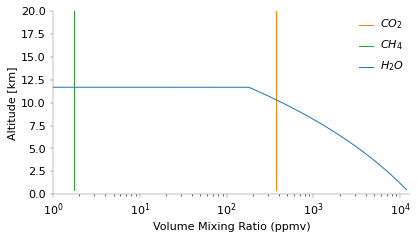

In [15]:
show_change = False
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in q_funcs:
    ax.plot(humidity.ppmv_from_humidity(
        q_funcs[key](atmos_base.p, *q_args[key]), key.upper()),
        p_altitude_convert(p=atmos_base.p)/1000, label=label_molecule[key.lower()], color=colors_molecule[key])
    if show_change:
        ax.plot(humidity.ppmv_from_humidity(
            q_funcs[key](atmos_base.p, *q_args_change[key+'_change'][key]), key.upper()),
            p_altitude_convert(p=atmos_base.p)/1000, linestyle='--', color=colors_molecule[key])
ax.set_ylim(0, 20)
ax.set_xscale('log')
ax.set_xlabel('Volume Mixing Ratio (ppmv)')
ax.set_ylabel('Altitude [km]')
ax.set_xlim(1, 13000)
update_linewidth_use(fig)
add_legend(ax)
update_fontsize_use(fig)
plt.show()
# savefig(fig)

### OLR spectrum of Base Climate
For the empty atmosphere, the starting OLR was just the surface emission. Here, the OLR differs from the surface blackbody, and is shown below with `key2=3`.
With `key2=1, 2` the OLR can be seen if just water or water+co2 in above concentrations present.

In [16]:
 # OLR with just water, then add co2, then add methane
molecules_earth = {1: ['h2o'], 2: ['h2o', 'co2'], 3: ['h2o', 'co2', 'ch4']}
olr_breakdown_earth = {key2: {key: np.zeros(n_bands) for key in ['all', 'surface', 'atmos']} for key2 in molecules_earth}
for key2 in molecules_earth:
    atmos_use = RealGas(nz='auto', ny=1, molecule_names=molecules_earth[key2], p_toa=p_toa,
                        q_funcs={key: q_funcs[key] for key in molecules_earth[key2]}, q_funcs_args={key: q_args[key] for key in molecules_earth[key2]},
                        T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown_earth[key2]['all'] = atmos_use.up_flux[0]
    var = atmos_use.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown_earth[key2]['surface'] = var['surface']
    olr_breakdown_earth[key2]['atmos'] = olr_breakdown_earth[key2]['all'] - olr_breakdown_earth[key2]['surface']

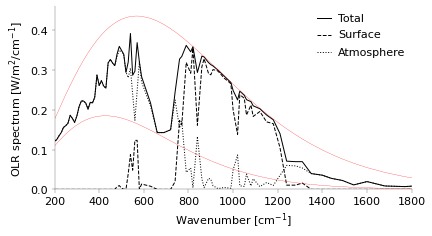

In [17]:
key2 = 3
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in olr_breakdown_earth[key2]:
    ax.plot(atmos_base.nu_bands['centre'], olr_breakdown_earth[key2][key], color='k', linestyle=linestyle_olr[key], label=label_olr[key])
update_linewidth_use(fig)
ax.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='r', lw=ax_linewidth)
ax.plot(atmos_base.nu_bands['centre'], spectrum_tropopause, color='r', lw=ax_linewidth)
ax.set_xlim(ax_lim_spectrum)
ax.set_ylim(ax_lim_flux)
ax.set_xlabel('Wavenumber [cm$^{-1}$]')
ax.set_ylabel('OLR spectrum [W/m$^2$/cm$^{-1}$]')
add_legend(ax, loc='upper right')
update_fontsize_use(fig)
# savefig(fig)

### Change in OLR with mass
Below, we plot the change in OLR due to adding mass equivalent to 50ppmv of CO2 to the atmosphere, across the entire atmospheric column (even for H20, just add at all altitudes).

In [18]:
# Look at effect of adding mass eqv to 5ppmv of CO2 and methane, what is the total effect?
co2_warm_change = 50
q_args_change = {}
q_args_change['co2_change'] = {key: q_args[key] for key in ['h2o', 'ch4']}
q_args_change['co2_change']['co2'] = (370+co2_warm_change, 'CO2')
q_args_change['ch4_change'] = {key: q_args[key] for key in ['h2o', 'co2']}
q_args_change['ch4_change']['ch4'] = (1.75+eqv_ppmv('ch4', co2_warm_change), 'CH4')
q_args_change['h2o_change'] = {key: q_args[key] for key in ['ch4', 'co2']}
q_args_change['h2o_change']['h2o'] = (0.7, eqv_ppmv('h2o', co2_warm_change), 'H2O')

for key2 in q_args_change:
    olr_breakdown_earth[key2] = {key: np.zeros(n_bands) for key in ['all', 'surface', 'atmos']}
    atmos_use = RealGas(nz='auto', ny=1, molecule_names=molecules_earth[3], p_toa=p_toa,
                        q_funcs={key: q_funcs[key] for key in molecules_earth[3]}, q_funcs_args={key: q_args_change[key2][key] for key in molecules_earth[3]},
                        T_func=temp_profile_use, n_nu_bands=n_bands)

    olr_breakdown_earth[key2]['all'] = atmos_use.up_flux[0]
    var = atmos_use.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown_earth[key2]['surface'] = var['surface']
    olr_breakdown_earth[key2]['atmos'] = olr_breakdown_earth[key2]['all'] - olr_breakdown_earth[key2]['surface']

In [19]:
# record change in overall olr from base climate
olr_change_area_diff = {key: get_olr_area(atmos_base, olr_breakdown_earth[3]['all']) - get_olr_area(atmos_base, olr_breakdown_earth[key]['all'])
                        for key in q_args_change}

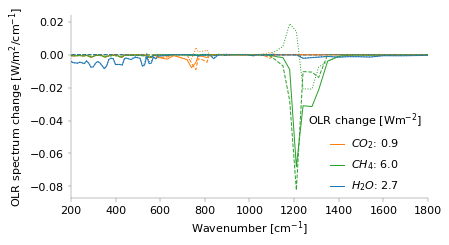

In [20]:
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in olr_breakdown_earth[3]:
    for key2 in q_args_change:
        ax.plot(atmos_base.nu_bands['centre'], olr_breakdown_earth[key2][key] - olr_breakdown_earth[3][key], color=colors_molecule[key2.replace('_change','')],
                linestyle=linestyle_olr[key], label=f"{label_molecule[key2.replace('_change','')]}: {olr_change_area_diff[key2]:.1f}" if key=='all' else None)
    # ax.plot(atmos_base.nu_bands['centre'], olr_breakdown_earth['ch4_change'][key] - olr_breakdown_earth[3][key], color=colors_molecule['ch4'],
    #         linestyle=linestyle_olr[key])
    # ax.plot(atmos_base.nu_bands['centre'], olr_breakdown_earth['h2o_change'][key] - olr_breakdown_earth[3][key], color=colors_molecule['h2o'],
    #         linestyle=linestyle_olr[key])
update_linewidth_use(fig)
# ax.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='r', lw=ax_linewidth)
# ax.plot(atmos_base.nu_bands['centre'], spectrum_tropopause, color='r', lw=ax_linewidth)
# ax.set_yscale('log')
ax.set_xlim(ax_lim_spectrum)
# ax.set_ylim(-0.3, 0.13)
ax.set_xlabel('Wavenumber [cm$^{-1}$]')
ax.set_ylabel('OLR spectrum change [W/m$^2$/cm$^{-1}$]')
add_legend(ax, loc='lower right', title='OLR change [Wm$^{-2}$]')
update_fontsize_use(fig)
# savefig(fig)